In [1]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

base_path = '/content/drive/My Drive/imagedata'
print(os.listdir(base_path))

['train', 'val', 'test', 'output.json', 'fasterrcnn_custom.pth', 'fasterrcnn_custom.pt', 'fasterrcnn_custom_new.pt']


In [5]:
import os
print(os.listdir('/content/drive/My Drive/yolodataset4'))


['data.yaml', 'test', 'val', 'train']


In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, labels_path, transforms=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transforms = transforms or torchvision.transforms.ToTensor()
        self.image_files = sorted(os.listdir(images_path))
        self.label_files = sorted(os.listdir(labels_path))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_path, image_file)
        image = Image.open(image_path).convert("RGB")

        label_file = self.label_files[idx]
        label_path = os.path.join(self.labels_path, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()

        boxes = []
        labels = []
        for line in lines:
            parts = line.strip().split()
            label = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2
            x_min *= image.width
            y_min *= image.height
            x_max *= image.width
            y_max *= image.height
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(label)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}
        image = self.transforms(image)  # Convert image to tensor

        return image, target

In [40]:
from torchvision.transforms import ToTensor

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, labels_path, transforms=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_path))
        self.label_files = sorted(os.listdir(labels_path))
        self.to_tensor = ToTensor()  # Convert PIL image to Tensor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_path, image_file)
        image = Image.open(image_path).convert("RGB")

        label_file = self.label_files[idx]
        label_path = os.path.join(self.labels_path, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()
        boxes = []
        labels = []
        for line in lines:
            parts = line.strip().split()
            label = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2
            x_min *= image.width
            y_min *= image.height
            x_max *= image.width
            y_max *= image.height
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(label)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        # Apply augmentations
        if self.transforms:
            image, target = self.transforms(image, target)

        # Convert image to tensor
        image = self.to_tensor(image)

        return image, target


In [10]:
from torchvision.transforms import functional as F

# def augment(image, target):
#     if target["labels"][0] == 0:  # SpeedLimit30
#         image = F.adjust_brightness(image, brightness_factor=0.5)
#         image = F.rotate(image, angle=15)
#     return image, target


In [11]:
# import torchvision.transforms as T

# transforms = T.Compose([
#     T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     T.RandomHorizontalFlip(),
#     T.RandomRotation(10),
#     T.ToTensor(),
# ])


In [41]:
# Paths to the dataset
images_path = "/content/drive/My Drive/yolodataset4/train/images"
labels_path = "/content/drive/My Drive/yolodataset4/train/labels"

# Instantiate the dataset
dataset_train = CustomDataset(images_path, labels_path)
# Paths to the dataset
images_path1 = "/content/drive/My Drive/yolodataset4/val/images"
labels_path1 = "/content/drive/My Drive/yolodataset4/val/labels"

# Instantiate the dataset
dataset_val = CustomDataset(images_path1, labels_path)

In [42]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(dataset_val, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [43]:
from torch.utils.data import ConcatDataset, DataLoader
combined_dataset = ConcatDataset([train_loader.dataset, val_loader.dataset])


In [45]:
combined_loader = DataLoader(
    combined_dataset,
    batch_size=train_loader.batch_size,  # Use the same batch size as train_loader
    shuffle=True,  # Shuffle to mix data from both datasets
    collate_fn=train_loader.collate_fn  # Use the same collate function
)

In [8]:
#Load pretrained model and modify the head
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 8  # Example: background + 2 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 171MB/s]


In [48]:
# Training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [49]:
num_epochs=10
model.train()  # Set model to training mode
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in tqdm(combined_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        # Filter out empty-label samples
        valid_indices = [i for i, t in enumerate(targets) if len(t["labels"]) > 0]
        if not valid_indices:
            continue  # Skip if all targets are empty

        images = [images[i].to(device) for i in valid_indices]
        targets = [{k: v.to(device) for k, v in targets[i].items()} for i in valid_indices]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    lr_scheduler.step()
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}")

# Save the model
# torch.save(model.state_dict(), "fasterrcnn_final.pth")

Epoch 1/10: 100%|██████████| 288/288 [10:33<00:00,  2.20s/it]


Epoch 1: Loss = 51.0400


Epoch 2/10: 100%|██████████| 288/288 [02:42<00:00,  1.78it/s]


Epoch 2: Loss = 28.9882


Epoch 3/10: 100%|██████████| 288/288 [02:42<00:00,  1.78it/s]


Epoch 3: Loss = 25.5042


Epoch 4/10: 100%|██████████| 288/288 [02:42<00:00,  1.77it/s]


Epoch 4: Loss = 19.2127


Epoch 5/10: 100%|██████████| 288/288 [02:42<00:00,  1.77it/s]


Epoch 5: Loss = 18.3465


Epoch 6/10: 100%|██████████| 288/288 [02:42<00:00,  1.78it/s]


Epoch 6: Loss = 17.6684


Epoch 7/10: 100%|██████████| 288/288 [02:41<00:00,  1.78it/s]


Epoch 7: Loss = 17.1881


Epoch 8/10: 100%|██████████| 288/288 [02:42<00:00,  1.78it/s]


Epoch 8: Loss = 16.5788


Epoch 9/10: 100%|██████████| 288/288 [02:42<00:00,  1.78it/s]


Epoch 9: Loss = 16.7533


Epoch 10/10: 100%|██████████| 288/288 [02:43<00:00,  1.76it/s]

Epoch 10: Loss = 16.7927


In [39]:
import torch.nn.functional as F

class_weights = torch.tensor([5.0, 1.0], device=device)  # Higher weight for SpeedLimit30

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Forward pass: Compute loss dictionary and predictions
        loss_dict = model(images, targets)  # Compute losses
        predictions = model(images)  # Compute predictions for logits

        # Extract logits and labels
        # 'scores' contains confidence scores for each predicted box
        logits = torch.cat([output['scores'] for output in predictions], dim=0)
        labels = torch.cat([target['labels'] for target in targets], dim=0)

        # Ensure logits have shape [N, num_classes]
        num_classes = len(class_weights)
        logits = logits.view(-1, num_classes)

        # Recompute weighted classification loss
        weighted_loss_classifier = F.cross_entropy(logits, labels, weight=class_weights)

        # Combine losses
        total_loss = (
            weighted_loss_classifier +
            loss_dict['loss_box_reg'] +
            loss_dict['loss_objectness'] +
            loss_dict['loss_rpn_box_reg']
        )

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    lr_scheduler.step()
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}")


Epoch 1/10:   0%|          | 0/211 [00:00<?, ?it/s]


IndexError: index 0 is out of bounds for dimension 0 with size 0

In [38]:
# Training loop
 #Define class weights
class_weights = torch.tensor([5.0, 1.0], device=device)  # Higher weight for SpeedLimit30
for param in model.backbone.parameters():
    param.requires_grad = False
num_epochs = 10
freeze_epochs = 3
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    if epoch == freeze_epochs:  # Unfreeze the backbone after freeze_epochs
        for param in model.backbone.parameters():
            param.requires_grad = True
        print("Unfroze backbone layers.")
    for images, targets in tqdm(combined_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
    lr_scheduler.step()
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}")

Epoch 1/10:   0%|          | 0/288 [00:00<?, ?it/s]


IndexError: index 0 is out of bounds for dimension 0 with size 0

In [50]:
torch.save(model.state_dict(), "/content/drive/My Drive/imagedata/fasterrcnn_custom_new.pt")

In [9]:
model.load_state_dict(torch.load("/content/drive/My Drive/imagedata/fasterrcnn_custom_new.pt"))
model.eval()

<ipython-input-9-3ebdfdabb30b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/imagedata/fasterrcnn_custom_new.pt"

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

50-1, 30-0

In [ ]:
def inspect_model_predictions(model, dataloader, device):
    """Analyze model predictions on the training data"""
    model.eval()
    all_predictions = []
    all_ground_truth = []
    all_scores = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]

            # Get model predictions
            predictions = model(images)

            # Collect predictions and ground truth
            for pred, target in zip(predictions, targets):
                # Get predictions above 0.5 confidence
                mask = pred['scores'] > 0.5
                pred_labels = pred['labels'][mask].cpu().numpy()
                pred_scores = pred['scores'][mask].cpu().numpy()

                all_predictions.extend(pred_labels)
                all_scores.extend(pred_scores)
                all_ground_truth.extend(target['labels'].numpy())

    print("\nPrediction Statistics:")
    pred_counts = Counter(all_predictions)
    for label, count in pred_counts.items():
        print(f"Class {label}: {count} predictions ({count/len(all_predictions)*100:.2f}%)")

    print("\nConfidence Score Statistics:")
    for label in set(all_predictions):
        scores = [score for pred, score in zip(all_predictions, all_scores) if pred == label]
        print(f"\nClass {label}:")
        print(f"Mean confidence: {np.mean(scores):.3f}")
        print(f"Min confidence: {np.min(scores):.3f}")
        print(f"Max confidence: {np.max(scores):.3f}")

    return all_predictions, all_ground_truth, all_scores

In [ ]:
# print(model.roi_heads.box_predictor.cls_score)
# print(f"Number of output classes: {model.roi_heads.box_predictor.cls_score.out_features}")

Linear(in_features=1024, out_features=2, bias=True)
Number of output classes: 2


In [ ]:
# for i in range(10):
#     image, target = dataset_train[i]
#     print("Labels:", target["labels"], "Boxes:", target["boxes"])

Labels: tensor([1]) Boxes: tensor([[266.3199, 166.4499, 362.0286, 285.4616]])
Labels: tensor([1]) Boxes: tensor([[267.1522, 225.5397, 421.9506, 375.3446]])
Labels: tensor([0]) Boxes: tensor([[155.6307,   9.9870, 486.8661, 360.3641]])
Labels: tensor([0]) Boxes: tensor([[383.6671, 192.2497, 468.5566, 275.4746]])
Labels: tensor([1]) Boxes: tensor([[135.6567,  29.1287, 505.1756, 405.3056]])
Labels: tensor([0]) Boxes: tensor([[390.3251, 293.7841, 440.2601, 342.8869]])
Labels: tensor([1]) Boxes: tensor([[260.4941, 133.1599, 426.1118, 322.0806]])
Labels: tensor([1]) Boxes: tensor([[283.7971, 262.9909, 547.6203, 506.0078]])
Labels: tensor([1]) Boxes: tensor([[362.0286, 215.5527, 426.1118, 284.6294]])
Labels: tensor([0]) Boxes: tensor([[266.3199, 257.9974, 462.7308, 438.5956]])


In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision.transforms import ToTensor
import os

def predict_image(model, image_path, device, confidence_threshold=0.5):
    """Make prediction on a single image"""
    image = Image.open(image_path).convert("RGB")
    transform = ToTensor()
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor)[0]

    return image, prediction

def show_prediction(image, prediction, confidence_threshold=0.5, figsize=(12, 8)):
    """Display image with predictions using matplotlib"""
    # Convert PIL image to numpy array for matplotlib
    img_np = np.array(image)

    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_np)

    # Define class names and colors
    class_names = {
        0: 'speed_30',
        1: 'speed_50'
    }
    colors = {
        0: 'red',
        1: 'green'
    }

    # Get predictions above threshold
    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    # Draw predictions
    for box, score, label in zip(boxes, scores, labels):
        if score > confidence_threshold:
            # Create rectangle patch
            rect = patches.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                linewidth=2,
                edgecolor=colors[label],
                facecolor='none'
            )
            ax.add_patch(rect)

            # Add label and score
            label_text = f"{class_names[label]}: {score:.2f}"
            ax.text(
                box[0], box[1] - 5,
                label_text,
                color=colors[label],
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
            )

    plt.axis('off')
    plt.show()

    # Print detection details
    print("\nDetailed predictions:")
    for box, score, label in zip(boxes, scores, labels):
        if score > confidence_threshold:
            print(f"Class: {class_names[label]}")
            print(f"Confidence: {score:.2f}")
            print(f"Box coordinates: {box.tolist()}\n")

def process_test_folder(model, test_folder, confidence_threshold=0.5):
    """Process and display predictions for all images in test folder"""
    device = next(model.parameters()).device

    for image_file in sorted(os.listdir(test_folder)):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"\nProcessing: {image_file}")
            image_path = os.path.join(test_folder, image_file)

            # Get prediction
            image, prediction = predict_image(model, image_path, device, confidence_threshold)

            # Show results
            show_prediction(image, prediction, confidence_threshold)


Processing: 30_001.png


KeyError: 2

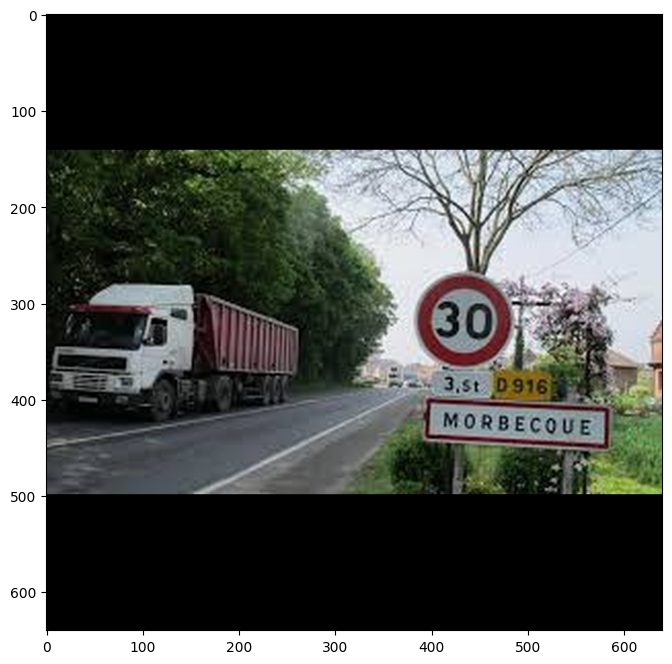

In [53]:
test_folder="/content/drive/My Drive/imagedata/test"
process_test_folder(model, test_folder, confidence_threshold=0.5)


In [10]:
!export LC_ALL=C.UTF-8
!export LANG=C.UTF-8
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 71.9 MB/s eta 0:00:00


In [14]:
# model.load_state_dict(torch.load("/content/drive/My Drive/imagedata/fasterrcnn_custom.pt"))
# model.eval()
# Example input for the model
dummy_input = torch.randn(1, 3, 224, 224)

# Export the model to ONNX format
torch.onnx.export(model, dummy_input, "/content/drive/My Drive/imagedata/fasterrcnn_custom_new.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})

In [15]:
import onnx
onnx_model = onnx.load("/content/drive/My Drive/imagedata/fasterrcnn_custom_new.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid.")

ONNX model is valid.
